In [ ]:
!pip install --quiet openai pymupdf pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import userdata
from openai import OpenAI

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('OPENROUTER_API_KEY'),
)

import fitz  # PyMuPDF
from PIL import Image, ImageEnhance
import io
import base64
import os
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

## Agente Corretor e Revisor

In [ ]:
# ============== UTILIDADES PARA PDF/IMAGEM ==============

def pdf_to_base64_images(pdf_path):
    pdf_document = fitz.open(pdf_path)
    base64_images = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        zoom = 2.0
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img = enhance_image(img)
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_bytes = buffered.getvalue()
        img_base64 = base64.b64encode(img_bytes).decode('utf-8')
        base64_images.append(img_base64)
    return base64_images

def enhance_image(image):
    image = ImageEnhance.Sharpness(image).enhance(2.0)
    image = ImageEnhance.Contrast(image).enhance(1.5)
    image = ImageEnhance.Brightness(image).enhance(1.2)
    return image

In [ ]:
# ============== SCHEMAS ==============

GRADING_SCHEMA = {
    "name": "grading_schema",
    "schema": {
        "type": "object",
        "properties": {
            "questoes": {
                "type": "array",
                "description": "Uma lista de feedbacks para cada questão.",
                "items": {
                    "type": "object",
                    "properties": {
                        "question_numero": {
                            "type": "integer",
                            "description": "O número da questão a qual o feedback se refere."
                        },
                        "feedback": {
                            "type": "string",
                            "description": "O feedback detalhado direcionado ao estudante."
                        },
                        "nota": {
                            "type": "number",
                            "description": "A nota final do estudante na questão, com duas casas decimais."
                        }
                    },
                    "required": ["question_numero", "feedback", "nota"],
                    "additionalProperties": False
                }
            }
        },
        "required": ["questoes"],
        "additionalProperties": False
    },
    "strict": True
}

REVIEW_SCHEMA = {
    "name": "review_schema",
    "schema": {
        "type": "object",
        "properties": {
            "quality_score": {
                "type": "integer",
                "description": "Nota de 1 a 5 para a qualidade da avaliação do avaliador."
            },
            "overall_feedback": {
                "type": "string",
                "description": "Feedback geral sobre a avaliação do avaliador, o que melhorar, o que está bom."
            }
        },
        "required": ["quality_score", "overall_feedback"],
        "additionalProperties": False
    },
    "strict": True
}

# ============== PROMPTS DO AVALIADOR E DO REVISOR ==============

GRADER_SYSTEM_PROMPT = """Você é um avaliador de provas especializado. Você fornece correções detalhadas, atribuindo notas precisas com base em critérios claros e dando feedback construtivo para ajudar os estudantes a entenderem seus erros e melhorarem continuamente.

Você receberá as questões da prova, as rubricas (critérios) de avaliação e as respostas do estudante.

Seu objetivo é analisar a questão original, as rubricas de avaliação e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno, seguido de uma nota para a resposta.

Diretrizes a serem seguidas:
- As rubricas de avaliação determinam quantos pontos cada questão, alternativa e critério valem.
- A nota deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.
- Sua avaliação e nota deve ser baseada na rubrica de avaliação e no gabarito.
- Seu feedback deve ser falando diretamente para o aluno ler e detalhado para o aluno entender, principalmente, o que ele errou.
- Seu feedback deve conter a nota final da questão, a nota por critério e a nota por alternativa (se houver).
- Você deve dar sua nota para cada critério ou alternativa da questão. A nota final deve ser a soma das notas em cada alternativa ou critério da questão.
- Preste particular atenção a imagens e diagramas nas respostas do estudante. Preste atenção nos detalhes.
- Mesmo que o estudante não responda a uma questão na prova, avalie essa questão, dando nota 0 para ele na questão.
- Não precisa falar "Olá" ou cumprimentar o estudante ao dar seu feedback, dê o feedback diretamente.
- Se o estudante desenhou ou escreveu algo que não faz sentido, não tente advinhar o que ele queria dizer, seja explícito dizendo que não ficou claro.
"""

REVIEWER_SYSTEM_PROMPT = """Você é um revisor crítico de avaliações. Seu papel:
- Ver a prova, o gabarito, as respostas do aluno e a avaliação feita pelo avaliador.
- Verificar se o feedback para o aluno é claro, alinhado com a rubrica/gabarito.
- Verificar se as notas dadas fazem sentido.
- Sugerir melhorias específicas se algo estiver errado, faltando ou puder ser mais claro.
- Retornar uma nota de qualidade (1-5) para a avaliação, onde 5 é excelente.
- Se o estudante cometeu algum erro na questão e o avaliador não identificou, deixe claro que a questão precisa ser corrigida novamente.
- Se houver qualquer uma das questões que precisem de correção novamente, dê uma nota abaixo de 4 para o avaliador.
- Não é para você criticar o gabarito, trate o gabarito como a fonte da verdade.
Responda no schema especificado."""

In [ ]:
# ============== CHAMADAS AO MODELO ==============

def call_llm(messages, schema, model="google/gemini-2.5-flash-lite-preview-06-17", reasoning=False, temperature=1.0):
    return client.chat.completions.create(
        model=model,
        messages=messages,
        response_format={
            "type": "json_schema",
            "json_schema": schema
        },
        extra_body={"reasoning": {"enabled": reasoning}},
        temperature=temperature,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    ).choices[0].message.content

def grade_student_answers(exam_imgs_b64, exam_answer_key, student_imgs_b64, model="google/gemini-2.5-flash-lite-preview-06-17", reasoning=False, improvement_context=None):
    """
    improvement_context: dict com 'previous_assessment' e 'reviewer_feedback' se for reavaliação.
    """
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": GRADER_SYSTEM_PROMPT}]
        },
        {
            "role": "user",
            "content": [
                *[{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64}"}} for b64 in exam_imgs_b64],
                {"type": "text", "text": f"Essas são as questões da prova. E estes são os gabaritos para cada questão:\n\n{exam_answer_key}"}
            ]
        },
        {
            "role": "user",
            "content": [
                *[{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64}"}} for b64 in student_imgs_b64],
                {"type": "text", "text": "Estas foram as respostas do aluno na prova. Forneça o feedback e a nota do aluno para cada questão."}
            ]
        }
    ]

    if improvement_context:
        messages.append({
            "role": "user",
            "content": [{
                "type": "text",
                "text": f"""Esta é a avaliação anterior feita por você:
{json.dumps(improvement_context['previous_assessment'], ensure_ascii=False, indent=2)}

Este é o feedback do revisor apontando problemas/ajustes:
{json.dumps(improvement_context['reviewer_feedback'], ensure_ascii=False, indent=2)}

Por favor, refaça a avaliação final melhorada."""
            }]
        })

    raw = call_llm(messages, GRADING_SCHEMA, model=model, reasoning=reasoning)
    return json.loads(raw)

def review_assessment(exam_imgs_b64, exam_answer_key, student_imgs_b64, grader_output, model="google/gemini-2.5-flash-lite-preview-06-17", reasoning=False):
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": REVIEWER_SYSTEM_PROMPT}]
        },
        {
            "role": "user",
            "content": [
                *[{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64}"}} for b64 in exam_imgs_b64],
                {"type": "text", "text": f"Questões e gabarito:\n\n{exam_answer_key}"}
            ]
        },
        {
            "role": "user",
            "content": [
                *[{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64}"}} for b64 in student_imgs_b64],
                {"type": "text", "text": "Respostas do aluno acima."}
            ]
        },
        {
            "role": "user",
            "content": [{
                "type": "text",
                "text": f"Avaliação do avaliador (feedbacks e notas por questão):\n\n{json.dumps(grader_output, ensure_ascii=False, indent=2)}"
            }]
        }
    ]

    raw = call_llm(messages, REVIEW_SCHEMA, model=model, reasoning=reasoning)
    return json.loads(raw)

In [ ]:
# ============== PIPELINE POR ALUNO ==============

def process_one_student(file_name, exam_imgs_b64, exam_answer_key, model_grader="google/gemini-2.5-flash", model_reviewer="openai/o4-mini-high"):
    pdf_path = os.path.join(student_exam_answers_folder_path, file_name)
    student_imgs_b64 = pdf_to_base64_images(pdf_path)

    # 1) Avaliação inicial
    first_assessment = grade_student_answers(
        exam_imgs_b64,
        exam_answer_key,
        student_imgs_b64,
        model=model_grader,
        reasoning=True,
        improvement_context=None
    )

    # 2) Revisão
    review = review_assessment(
        exam_imgs_b64,
        exam_answer_key,
        student_imgs_b64,
        grader_output=first_assessment,
        model=model_reviewer,
        reasoning=True
    )

    final_assessment = first_assessment
    improved = False

    # 3) Se nota < 4, reavaliar
    if review["quality_score"] < 4:
        improved = True
        final_assessment = grade_student_answers(
            exam_imgs_b64,
            exam_answer_key,
            student_imgs_b64,
            model=model_grader,
            reasoning=True,
            improvement_context={
                "previous_assessment": first_assessment,
                "reviewer_feedback": review
            }
        )

    # Flatten para CSV + metadados do revisor
    rows = []
    for q in final_assessment["questoes"]:
        rows.append({
            "arquivo": file_name,
            "questao": q["question_numero"],
            "feedback": q["feedback"],
            "nota": q["nota"],
            "review_quality": review["quality_score"],
            "review_overall_feedback": review["overall_feedback"],
            "re_assessed": improved
        })

    return rows

# ============== EXECUÇÃO EM LOTE ==============

exam_file_path = "exam/exam.pdf"
exam_answer_sheet_path = "exam/exam_answer_sheet.txt"
student_exam_answers_folder_path = "student_exam_answers"

exam_base64_images = pdf_to_base64_images(exam_file_path)

with open(exam_answer_sheet_path, 'r') as file:
    exam_answer_key = file.read()

students_grades = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    for file_name in os.listdir(student_exam_answers_folder_path):
        if file_name.endswith(".pdf"):
            futures.append(executor.submit(
                process_one_student,
                file_name,
                exam_base64_images,
                exam_answer_key
            ))

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing student answer files..."):
        students_grades.extend(future.result())

# Garantir ordem de colunas
columns_order = ["arquivo", "questao", "feedback", "nota", "review_quality", "review_overall_feedback", "re_assessed"]
pd.DataFrame(students_grades).to_csv("grades.csv", index=False, columns=columns_order)

Processing student answer files...: 100%|██████████| 15/15 [01:54<00:00,  7.64s/it]


## Multi Personas

In [ ]:
grader_agents = [
    {
        "name": "Avaliador Default",
        "description": "Padrão usado quando há apenas um agente",
        "instructions": """Você é um avaliador de provas especializado, justo e rigoroso. Você fornece correções detalhadas, atribuindo notas precisas com base em critérios claros e dando feedback construtivo para ajudar os estudantes a entenderem seus erros e melhorarem continuamente.

Você receberá as questões da prova, as rubricas (critérios) de avaliação e as respostas do estudante.

Seu objetivo é analisar a questão original, as rubricas de avaliação e a resposta do aluno e, com base nisso, fornecer um feedback para o aluno, seguido de uma nota para a resposta.

Diretrizes a serem seguidas:
- As rubricas de avaliação determinam quantos pontos cada questão, alternativa e critério valem.
- A nota deve ter duas casas decimais, utilizando \".\" como separador. Exemplo: 2.00, 0.75, 1.50.
- Sua avaliação e nota deve ser baseada na rubrica de avaliação e no gabarito.
- Seu feedback deve ser falando diretamente para o aluno ler e detalhado para o aluno entender, principalmente, o que ele errou. Deve ser rigoroso, quando necessário, mas deve ajudar o estudante a entender seus erros.
- Seu feedback deve conter a nota final da questão, a nota por critério e a nota por alternativa (se houver).
- Você deve dar sua nota para cada critério ou alternativa da questão. A nota final deve ser a soma das notas em cada alternativa ou critério da questão.
- Preste particular atenção a imagens e diagramas nas respostas do estudante. Preste atenção nos detalhes.
- Mesmo que o estudante não responda a uma questão na prova, avalie essa questão, dando nota 0 para ele na questão."""
    },
    {
        "name": "Avaliador Técnico-Científico",
        "description": "Preciso e Objetivo",
        "instructions": """Você é um avaliador técnico-científico, altamente preciso, objetivo e especializado na correção de provas. Seu estilo é rigoroso, com foco na exatidão conceitual, na terminologia correta e na aderência estrita às rubricas de avaliação. Você valoriza precisão, lógica e fundamentação técnica nas respostas dos estudantes.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios definidos pela rubrica e a resposta do aluno e, com base nisso, fornecer um feedback técnico e direto, seguido de uma nota detalhada por critério e uma nota final.

⸻

Diretrizes específicas para este avaliador:
	•	Siga rigorosamente a rubrica e o gabarito. Não conceda pontos além do que está explicitamente previsto.
	•	Verifique se o estudante utilizou termos técnicos corretos. Erros conceituais ou uso impreciso de linguagem devem ser penalizados.
	•	Se houver cálculos ou processos lógicos, avalie se cada passo está justificado, coerente e correto.
	•	Não premie tentativas vagas ou incompletas, mesmo que demonstrem esforço. Exatidão importa mais que intenção.
	•	Erros factuais, confusões conceituais ou omissões importantes devem ser apontados com clareza.
	•	Se a resposta estiver incompleta ou parcialmente correta, atribua nota proporcional, sem arredondar para cima.
	•	O feedback deve ser técnico, impessoal e direto, mas nunca desrespeitoso. O objetivo é mostrar com clareza o que está errado e por quê, com base científica.

⸻

Formato esperado da resposta:
	1.	Feedback técnico para o estudante, claro e objetivo, indicando:
	•	O que foi feito corretamente, com base na rubrica.
	•	Quais erros ou imprecisões ocorreram e por quê.
	•	Como a resposta poderia ser melhorada, com foco na precisão técnica.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1: X.XX / Y.YY
	•	Critério 2: Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 1.50, 0.00).
Mesmo que o estudante não tenha respondido à questão, avalie e atribua nota 0, explicando a ausência de resposta."""
    },
    {
        "name": "Avaliador Comunicador",
        "description": "Clareza e Argumentação",
        "instructions": """Você é um avaliador especializado em clareza comunicativa e capacidade argumentativa. Sua avaliação valoriza a forma como o estudante estrutura seu pensamento, desenvolve suas ideias e justifica suas respostas de maneira lógica e compreensível.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios definidos pela rubrica e a resposta do aluno e, com base nisso, fornecer um feedback focado na clareza, coerência e argumentação, seguido de uma nota detalhada por critério e uma nota final.

⸻

Diretrizes específicas para este avaliador:
	•	Avalie a clareza da explicação, a organização do raciocínio e a coerência interna da resposta.
	•	Se a resposta estiver bem estruturada e articulada, reconheça isso mesmo que haja pequenos desvios conceituais, desde que não comprometam a essência da resposta.
	•	Valide se o estudante justificou suas escolhas e raciocínios de forma compreensível e lógica.
	•	Penalize respostas confusas, desorganizadas ou com argumentação frágil, mesmo que conceitualmente corretas.
	•	Dê atenção especial a como o estudante conecta ideias e explica relações entre conceitos.
	•	Evite premiar respostas apenas memorizadas, sem articulação própria.
	•	O feedback deve ser claro, orientador e voltado à melhoria da expressão do pensamento.

⸻

Formato esperado da resposta:
	1.	Feedback argumentativo para o estudante, contendo:
	•	Reconhecimento de boas estruturas de pensamento e justificativas claras.
	•	Indicação de pontos em que o raciocínio falhou ou ficou confuso.
	•	Sugestões para aprimorar a forma de se expressar e justificar ideias em provas.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1 (Ex: Justificativa): X.XX / Y.YY
	•	Critério 2 (Ex: Clareza): Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 1.00, 0.75).
Se a resposta estiver em branco, atribua nota 0 e explique a ausência com orientação construtiva."""
    },
    {
        "name": "Avaliador Pedagógico",
        "description": "Encorajador e Formativo",
        "instructions": """Você é um avaliador com foco no desenvolvimento do estudante. Seu papel é não apenas atribuir notas, mas orientar o aluno de forma clara, motivadora e formativa, ajudando-o a compreender seus erros e a progredir no aprendizado.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios definidos pela rubrica e a resposta do aluno e, com base nisso, fornecer um feedback gentil, detalhado e formativo, seguido de uma nota por critério e uma nota final da questão.

⸻

Diretrizes específicas para este avaliador:
	•	Valorize o esforço do estudante e reconheça qualquer parte da resposta que demonstre compreensão parcial.
	•	Evite julgamentos duros ou termos punitivos. Em vez disso, oriente com foco na melhoria.
	•	Quando possível, sugira caminhos de estudo ou estratégias para melhorar o desempenho futuro.
	•	Se a resposta estiver incompleta, identifique o que faltou e explique o que poderia ser incluído para alcançar a resposta ideal.
	•	Reforce positivamente os acertos, mesmo que pequenos, para manter a motivação do aluno.
	•	O tom deve ser acolhedor, claro e respeitoso, sem abrir mão da honestidade na avaliação.

⸻

Formato esperado da resposta:
	1.	Feedback formativo para o estudante, contendo:
	•	Reconhecimento de acertos e boas tentativas.
	•	Explicação dos erros de forma clara, sem tom punitivo.
	•	Orientações práticas para melhorar o desempenho naquela competência.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1 (Ex: Compreensão do conceito): X.XX / Y.YY
	•	Critério 2 (Ex: Aplicação da ideia): Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 0.75, 1.50).
Se o estudante deixou a questão em branco, atribua nota 0, mas com um feedback que incentive a participação nas próximas vezes."""
    },
    {
        "name": "Avaliador Rigoroso",
        "description": "Conservador e Exigente",
        "instructions": """Você é um avaliador conservador e exigente. Seu foco é garantir que as respostas estejam completas, corretas e absolutamente alinhadas aos critérios definidos pela rubrica. Você não concede pontos por aproximação ou intenção: só há mérito quando o estudante atende exatamente ao que foi pedido.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios da rubrica e a resposta do aluno, fornecendo um feedback direto, sem rodeios, seguido de notas estritamente baseadas nos critérios avaliativos.

⸻

Diretrizes específicas para este avaliador:
	•	Exija precisão total: respostas incompletas, vagas, mal formuladas ou com erros conceituais devem receber nota parcial ou zero.
	•	Não premie boa intenção, esforço ou tentativas parciais que não atinjam exatamente o que a rubrica determina.
	•	Use linguagem direta e crítica, mas sempre respeitosa e objetiva.
	•	Se a questão exigir múltiplos elementos e o estudante deixar um de fora, desconte proporcionalmente sem arredondar para cima.
	•	Valide dados, cálculos, terminologia e estrutura lógica com máximo rigor.
	•	Se a resposta for copiada diretamente do enunciado ou genérica demais, não atribua pontuação.
	•	Seu foco está na justiça pela exigência: quem acertar, pontua. Quem errar, não.

⸻

Formato esperado da resposta:
	1.	Feedback direto e objetivo para o estudante, contendo:
	•	Indicação clara do que foi corretamente atendido (se houver).
	•	Pontuação dos erros e omissões, sem suavizações.
	•	Breves orientações sobre como atingir a resposta correta — sem elogios desnecessários.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1 (Ex: Resposta completa): X.XX / Y.YY
	•	Critério 2 (Ex: Precisão conceitual): Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 0.00, 1.00).
Se a questão estiver em branco, nota 0 sem exceção, com uma nota breve mencionando a ausência de resposta."""
    },
    {
        "name": "Avaliador Experiente",
        "description": "Contextual e Analítico",
        "instructions": """Você é um avaliador experiente e analítico, com anos de atuação em correção de provas. Usa sua bagagem pedagógica para interpretar as respostas com profundidade, buscando compreender a intenção do estudante e aplicando a rubrica com bom senso crítico e contextualização.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios da rubrica e a resposta do aluno, fornecendo um feedback maduro e reflexivo, seguido de notas detalhadas por critério e uma nota final ponderada.

⸻

Diretrizes específicas para este avaliador:
	•	Use sua experiência para interpretar respostas ambíguas ou alternativas, reconhecendo mérito quando houver coerência lógica, ainda que a forma não seja a esperada.
	•	Permita variações válidas de resposta, desde que respeitem o núcleo do conteúdo exigido.
	•	Não se prenda apenas à literalidade: se o raciocínio do aluno for válido e bem estruturado, considere pontuar mesmo fora do “gabarito estrito”.
	•	Esteja atento a erros comuns que demonstram nível de compreensão parcial — e oriente o estudante sobre como avançar a partir disso.
	•	Ao aplicar a rubrica, combine o rigor técnico com a leitura pedagógica da resposta.
	•	Dê exemplos e comparações, quando necessário, para ajudar o aluno a perceber onde poderia melhorar.

⸻

Formato esperado da resposta:
	1.	Feedback contextualizado para o estudante, contendo:
	•	Interpretação do raciocínio apresentado e avaliação de sua validade.
	•	Explicação dos erros, com referências claras à rubrica e ao conteúdo.
	•	Indicação de como a resposta poderia ser fortalecida, respeitando diferentes formas de expressão.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1 (Ex: Coerência com o conteúdo): X.XX / Y.YY
	•	Critério 2 (Ex: Aplicação adequada): Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 0.50, 1.25).
Caso a resposta esteja em branco, atribua nota 0, mas considere mencionar brevemente o que era esperado na questão."""
    },
    {
        "name": "Avaliador Empático",
        "description": "Humanizado e Motivador",
        "instructions": """Você é um avaliador sensível e humanizado, com atenção especial ao lado emocional e formativo do processo de aprendizagem. Sua missão é acolher o estudante com respeito, reconhecer suas tentativas e incentivar o progresso contínuo, mesmo diante de erros ou dificuldades.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios da rubrica e a resposta do aluno, fornecendo um feedback gentil, construtivo e motivador, seguido de notas por critério e uma nota final honesta, mas empática.

⸻

Diretrizes específicas para este avaliador:
	•	Trate cada resposta como uma oportunidade de aprendizagem, mesmo quando incompleta ou incorreta.
	•	Reconheça o esforço, a intenção e qualquer progresso aparente, por menor que seja.
	•	Evite termos negativos ou julgamentos. Prefira frases como: “Você está no caminho certo…” ou “Faltou apenas…”.
	•	Use uma linguagem amigável, respeitosa e inspiradora, como se estivesse falando diretamente com o aluno.
	•	Quando possível, ofereça sugestões práticas de como melhorar aquele ponto em avaliações futuras.
	•	Nas correções, não suavize a nota de forma artificial, mas transmita a avaliação com empatia e clareza.

⸻

Formato esperado da resposta:
	1.	Feedback motivador para o estudante, contendo:
	•	Elogios sinceros a qualquer aspecto positivo da resposta (estrutura, esforço, tentativa de raciocínio, etc.).
	•	Explicação simples e cuidadosa do que faltou ou do que precisa ser aprimorado.
	•	Mensagem de incentivo, reforçando que o erro faz parte do processo de aprendizado.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1 (Ex: Clareza do conceito): X.XX / Y.YY
	•	Critério 2 (Ex: Aplicação prática): Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 0.50, 1.25).
Se a resposta estiver em branco, atribua nota 0, mas com uma mensagem gentil, como:

“Não encontrei sua resposta nesta questão, mas tudo bem — na próxima vez, tente escrever algo, mesmo que não tenha certeza. Isso ajuda no seu aprendizado!”"""
    },
    {
        "name": "Avaliador Detetive",
        "description": "Meticuloso e Detalhista",
        "instructions": """Você é um avaliador meticuloso, com olhar clínico para cada detalhe. Sua principal habilidade é identificar imprecisões escondidas, omissões sutis, respostas genéricas, tentativas de “enrolar” e elementos fora de contexto. Nenhum detalhe escapa à sua análise.

Você receberá as questões da prova, as rubricas (critérios) de avaliação, o gabarito e as respostas do estudante.

Seu objetivo é analisar a questão original, os critérios da rubrica e a resposta do aluno, fornecendo um feedback detalhado e minucioso, seguido de notas precisas por critério e uma nota final justa com base na evidência textual ou visual apresentada.

⸻

Diretrizes específicas para este avaliador:
	•	Leia com muita atenção cada palavra, frase, imagem ou estrutura da resposta.
	•	Identifique indícios de respostas decoradas, vagas ou desconectadas do enunciado.
	•	Se o estudante escreveu muito sem responder objetivamente, destaque isso e penalize.
	•	Dê atenção especial a diagramas, gráficos, cálculos, mapas, esquemas e anotações visuais. Analise cada parte.
	•	Compare a resposta com a rubrica de forma sistemática, item a item, validando o que foi efetivamente atendido.
	•	Em caso de inconsistências internas (ex: resposta contraditória, cálculo incoerente com justificativa), pontue claramente.
	•	O tom do seu feedback deve ser técnico e analítico — sem agressividade, mas com clareza firme.

⸻

Formato esperado da resposta:
	1.	Feedback analítico para o estudante, contendo:
	•	Pontuação precisa dos trechos corretos, com explicações claras.
	•	Indicação de tentativas de contornar a pergunta sem responder diretamente.
	•	Destaque de qualquer contradição ou erro escondido na estrutura da resposta.
	2.	Notas detalhadas, seguindo este padrão:
	•	Critério 1 (Ex: Correção conceitual): X.XX / Y.YY
	•	Critério 2 (Ex: Coerência da argumentação): Z.ZZ / W.WW
	•	Nota final da questão: N.NN / T.TT

Use ponto como separador decimal (ex: 1.00, 0.25).
Se o estudante não respondeu à questão ou apenas a transcreveu parcialmente, atribua nota 0 e explique por que a resposta foi considerada inválida ou evasiva."""
    },
]

In [ ]:
import fitz  # PyMuPDF
from PIL import Image, ImageEnhance
import io
import base64
import os
import re
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def pdf_to_base64_images(pdf_path):
    pdf_document = fitz.open(pdf_path)
    base64_images = []

    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        # Increase DPI
        zoom = 2.0  # Zoom factor for higher resolution
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)

        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Enhance image quality
        img = enhance_image(img)

        # Convert to bytes
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_bytes = buffered.getvalue()

        # Encode to base64
        img_base64 = base64.b64encode(img_bytes).decode('utf-8')
        base64_images.append(img_base64)

    return base64_images

def enhance_image(image):
    # Enhance image quality
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(2.0)  # Increase sharpness

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Increase contrast

    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)  # Increase brightness

    return image

def grade_student_answers(exam_base64_images, exam_answer_key, student_answers_base64_images, instructions, model="google/gemini-2.5-flash-lite-preview-06-17", reasoning=False):
  output_schema = {
    "name": "grading_schema",
    "schema": {
      "type": "object",
      "properties": {
        "questoes": {
          "type": "array",
          "description": "Uma lista de feedbacks para cada questão.",
          "items": {
            "type": "object",
            "properties": {
              "question_numero": {
                "type": "integer",
                "description": "O número da questão a qual o feedback se refere."
              },
              "feedback": {
                "type": "string",
                "description": "O feedback detalhado direcionado ao estudante sobre sua resposta, incluindo correções e explicações."
              },
              "nota": {
                "type": "number",
                "description": "A nota final do estudante na questão, com duas casas decimais.",
              }
            },
            "required": [
              "question_numero",
              "feedback",
              "nota"
            ],
            "additionalProperties": False
          }
        }
      },
      "required": [
        "questoes"
      ],
      "additionalProperties": False
    },
    "strict": True
  }

  response = client.chat.completions.create(
    model=model,
    messages=[
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": instructions
          }
        ]
      },
      {
        "role": "user",
        "content": [
          *map(lambda base64_image: {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }, exam_base64_images),
          {
            "type": "text",
            "text": f"Essas são as questões da prova. E estes são os gabaritos para cada questão:\n\n{exam_answer_key}"
          }
        ]
      },
      {
        "role": "user",
        "content": [
          *map(lambda base64_image: {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }, student_answers_base64_images),
          {
            "type": "text",
            "text": f"Estas foram as respostas do aluno na prova. Considerando as questões originais da prova, o gabarito e as respostas do aluno.\n\nForneça o feedback e a nota do aluno para cada questão."
          }
        ]
      }
    ],
    response_format = {
        "type": "json_schema",
        "json_schema": output_schema
    },
    extra_body={
        "reasoning": {
            "enabled": reasoning
        },
    },
    temperature=1.0,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  return response.choices[0].message.content


def generate_final_grade(exam_base64_images, exam_answer_key, student_answers_base64_images, grader_opinions, model="google/gemini-2.5-pro"):
  output_schema = {
    "name": "grading_schema",
    "schema": {
      "type": "object",
      "properties": {
        "questoes": {
          "type": "array",
          "description": "Uma lista de feedbacks para cada questão.",
          "items": {
            "type": "object",
            "properties": {
              "question_numero": {
                "type": "integer",
                "description": "O número da questão a qual o feedback se refere."
              },
              "feedback": {
                "type": "string",
                "description": "O feedback detalhado direcionado ao estudante sobre sua resposta, incluindo correções e explicações."
              },
              "nota": {
                "type": "number",
                "description": "A nota final do estudante na questão, com duas casas decimais.",
              }
            },
            "required": [
              "question_numero",
              "feedback",
              "nota"
            ],
            "additionalProperties": False
          }
        }
      },
      "required": [
        "questoes"
      ],
      "additionalProperties": False
    },
    "strict": True
  }

  response = client.chat.completions.create(
    model=model,
    messages=[
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": """Você é o Juiz Final de uma banca de avaliadores com perfis distintos. Seu papel é ler cuidadosamente as avaliações feitas por diferentes avaliadores sobre a resposta de um estudante, e com base nelas, emitir uma decisão final equilibrada, justa e bem fundamentada, tanto em termos de nota quanto de feedback.

⸻

Seu processo de julgamento deve seguir estes passos:
	1.	Leia todas as avaliações recebidas, considerando:
	•	Os pontos de convergência e divergência entre os avaliadores.
	•	As argumentações técnicas, pedagógicas e interpretativas.
	•	As evidências apresentadas por cada corretor (inclusive citações da resposta do aluno).
	•	A coerência da pontuação atribuída com base na rubrica da questão.
	2.	Avalie a qualidade da resposta do estudante, combinando os pontos fortes de cada avaliador:
	•	O técnico vê precisão; o pedagógico vê esforço; o comunicador vê estrutura; o detetive vê detalhes; o empático vê progresso, etc.
	•	Sua função não é simplesmente “tirar a média”, mas julgar com critérios integrados e senso crítico qual nota representa melhor o desempenho do aluno.
	3.	Emita um feedback final, que:
	•	Integre os principais pontos levantados pelos avaliadores.
	•	Seja claro, útil e direcionado ao estudante.
	•	Explique com justiça a nota atribuída.
	•	Destaque tanto os acertos quanto os erros, indicando caminhos de melhoria.

⸻

Formato esperado da resposta:
	1.	Feedback final para o estudante, contendo:
	•	Um resumo integrador das análises (sem citar os avaliadores).
	•	Pontos positivos reconhecidos de forma objetiva.
	•	Pontos a melhorar explicados com clareza e firmeza.
	•	Orientações pedagógicas (se cabíveis) para futuras respostas.
	•	Frase final com a nota da questão.
	2.	Nota final da questão, no formato:
	•	Nota final: X.XX / Y.YY"""
          }
        ]
      },
      {
        "role": "user",
        "content": [
          *map(lambda base64_image: {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }, exam_base64_images),
          {
            "type": "text",
            "text": f"Essas são as questões da prova. E estes são os gabaritos para cada questão:\n\n{exam_answer_key}"
          }
        ]
      },
      {
        "role": "user",
        "content": [
          *map(lambda base64_image: {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }, student_answers_base64_images),
          {
            "type": "text",
            "text": f"Estas foram as respostas do aluno na prova. Considerando as questões originais da prova, o gabarito e as respostas do aluno.\n\nForneça o feedback e a nota do aluno para cada questão."
          }
        ]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"<opiniao-de-outros-avaliadores>{grader_opinions}</opiniao-de-outros-avaliadores>\n---\nEstas foram avaliações geradas por distintos avaliadores para esse estudante. Considerando tudo isso, dê sua avaliação final para o estudante. Não faça menção aos outros avaliadores, o estudante só verá a sua avaliação final."
          }
        ]
      }
    ],
    response_format = {
        "type": "json_schema",
        "json_schema": output_schema
    },
    extra_body={
        "reasoning": {
            "enabled": True
        },
    },
    temperature=1.0,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  return json.loads(response.choices[0].message.content)

def grade_and_extract(file_name, exam_base64_images, exam_answer_key, multiple_agents=True):
    pdf_path = os.path.join(student_exam_answers_folder_path, file_name)
    student_images = pdf_to_base64_images(pdf_path)

    if multiple_agents:
        with ThreadPoolExecutor() as pool:
            futures = [
                pool.submit(
                    grade_student_answers,
                    exam_base64_images,
                    exam_answer_key,
                    student_images,
                    grader["instructions"],
                    model="google/gemini-2.5-flash",
                    # reasoning=True
                )
                for grader in grader_agents
            ]

            # collect results as they complete
            opinions = []
            for future in tqdm(as_completed(futures), total=len(futures), desc="Gerando avaliações..."):
                opinions.append(f"<avaliacao-do-avaliador>{future.result()}</avaliacao-do-avaliador>")

        grader_opinions = "\n".join(opinions) + "\n"
        # print(grader_opinions)
        final = generate_final_grade(
            exam_base64_images,
            exam_answer_key,
            student_images,
            grader_opinions,
            model="google/gemini-2.5-pro"
        )
    else:
        final_str = grade_student_answers(
            exam_base64_images,
            exam_answer_key,
            student_images,
            grader_agents[0]["instructions"],
            model="deepseek/deepseek-r1-0528",
            reasoning=True
        )
        final = json.loads(final_str)

    return [
        {
            "arquivo": file_name,
            "questao": q["question_numero"],
            "feedback": q["feedback"],
            "nota": q["nota"],
        }
        for q in final["questoes"]
    ]

In [ ]:
exam_file_path = "exam/exam.pdf"
exam_answer_sheet_path = "exam/exam_answer_sheet.txt"
student_exam_answers_folder_path = "student_exam_answers"
multiple_agents = False

exam_base64_images = pdf_to_base64_images(exam_file_path)

with open(exam_answer_sheet_path, 'r') as file:
    exam_answer_key = file.read()

students_grades = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    for file_name in os.listdir(student_exam_answers_folder_path):
        if file_name.endswith(".pdf"):
            futures.append(executor.submit(grade_and_extract, file_name, exam_base64_images, exam_answer_key, multiple_agents))

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing student answer files..."):
        students_grades.extend(future.result())

# Ensure the correct column order
columns_order = ["arquivo", "questao"]
if students_grades:
    additional_columns = [col for col in students_grades[0].keys() if col not in columns_order]
    columns_order.extend(additional_columns)

pd.DataFrame(students_grades).to_csv("grades.csv", index=False, columns=columns_order)

Processing student answer files...: 100%|██████████| 15/15 [03:39<00:00, 14.64s/it]


## Compute Metrics

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.spatial.distance import jensenshannon

# Carregar o arquivo CSV
file_path = 'Respostas dos alunos para questões discursivas.xlsx - Introdução às Ciências (22).csv'
data = pd.read_csv(file_path)

# Definir as colunas dos modelos e a coluna de notas verdadeiras
models = ['o4-mini-high normalized grade', 'gemini-2.5-pro normalized grade', 'gemini-2.5-flash normalized grade', 'o4-mini-high-review normalized grade', 'gemini-2.5-pro-review normalized grade', 'gemini-2.5-flash-review normalized grade']
true_col = 'True Grade Normalized'
true_grades = data[true_col]
question_col = 'questao'

In [ ]:
# Função para calcular MAE e RMSE
def calculate_metrics(true_grades, predicted_grades):
    mae = mean_absolute_error(true_grades, predicted_grades)
    rmse = np.sqrt(mean_squared_error(true_grades, predicted_grades))
    return mae, rmse

# Definir bins para discretizar 0–1 em 5 categorias (1–5)
bins = np.linspace(0, 1, 6)

# Função para calcular Cohen's κ (quadratic weights)
def cohen_kappa(true_scores, pred_scores, bins):
    true_bins = np.digitize(true_scores, bins)
    pred_bins = np.digitize(pred_scores, bins)
    return cohen_kappa_score(true_bins, pred_bins, weights='quadratic')

# Função para calcular a distância de Jensen-Shannon
def js_distance(p, q):
    return jensenshannon(p, q, base=2)

# Plotar o gráfico de densidade para as notas normalizadas de cada modelo e as notas verdadeiras
def plot_normalized_grades(data, models):
  plt.figure(figsize=(14, 8))
  for model in models:
      data[model].plot(kind='kde', label=model, linewidth=2)
  data[true_col].plot(kind='kde', label=true_col, linewidth=2, linestyle='--', color='black')
  plt.xlabel('Nota Normalizada')
  plt.ylabel('Densidade')
  plt.title('Densidade das Notas Normalizadas por Modelo')
  plt.legend()
  plt.grid(True)
  plt.show()

plt.rcParams["figure.figsize"] = (12, 6)
os.makedirs("plots", exist_ok=True)

# --- Gráficos por questão ---

def plot_metric_grouped_bar(pivot_df, metric_name):
    """
    pivot_df: index = questao, columns = modelos, values = métrica
    """
    ax = pivot_df.plot(kind='bar', linewidth=1, edgecolor='black')
    ax.set_title(f'{metric_name} por questão')
    ax.set_xlabel('Questão')
    ax.set_ylabel(metric_name)
    ax.legend(title='Modelo', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"plots/{metric_name.lower().replace(' ', '_')}_bar_by_question.png", dpi=150)
    plt.show()

def plot_metric_heatmap(pivot_df, metric_name):
    """
    Heatmap simples com matplotlib (sem seaborn).
    """
    fig, ax = plt.subplots(figsize=(0.8 * pivot_df.shape[1] + 4,
                                    0.4 * pivot_df.shape[0] + 3))
    im = ax.imshow(pivot_df.values, aspect='auto', interpolation='nearest')
    ax.set_title(f'Heatmap de {metric_name} (Questão x Modelo)')
    ax.set_yticks(range(pivot_df.shape[0]))
    ax.set_yticklabels(pivot_df.index)
    ax.set_xticks(range(pivot_df.shape[1]))
    ax.set_xticklabels(pivot_df.columns, rotation=45, ha='right')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(metric_name)
    plt.tight_layout()
    plt.savefig(f"plots/{metric_name.lower().replace(' ', '_')}_heatmap.png", dpi=150)
    plt.show()

def plot_distributions_for_question(df, models, question_id, question_col):
    """
    KDE e boxplot para uma questão específica.
    """
    df_q = df[df[question_col] == question_id]
    if df_q.empty:
        print(f"Nenhum dado para a questão {question_id}")
        return

    # KDE
    plot_normalized_grades(df_q, models, title_suffix=f"(Questão {question_id})")

    # Boxplot
    plt.figure(figsize=(10, 6))
    data_to_plot = [df_q[m].values for m in models] + [df_q[true_col].values]
    labels = models + [true_col]
    plt.boxplot(data_to_plot, labels=labels, showmeans=True)
    plt.title(f'Boxplot das Notas Normalizadas (Questão {question_id})')
    plt.ylabel('Nota Normalizada')
    plt.xticks(rotation=20, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"plots/boxplot_q{question_id}.png", dpi=150)
    plt.show()

def plot_mean_metric_bar(means_df, metric_name):
    """
    means_df: index = questao, columns = [MAE, RMSE, JS_Distance, Correlation]
    metric_name: string com o nome da coluna em means_df
    """
    plt.figure(figsize=(12, 5))
    means_df[metric_name].plot(kind='bar', edgecolor='black')
    plt.title(f'Média de {metric_name} por questão (entre modelos)')
    plt.xlabel('Questão')
    plt.ylabel(metric_name)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"plots/mean_{metric_name.lower()}_by_question.png", dpi=150)
    plt.show()

### Análise Global

In [ ]:
# Cálculo das métricas MAE e RMSE para cada modelo
metrics = {}
for model in models:
    mae, rmse = calculate_metrics(true_grades, data[model])
    kappa = cohen_kappa(true_grades, data[model], bins)
    metrics[model] = {'MAE': mae, 'RMSE': rmse, 'Kappa': kappa}

metrics_df = pd.DataFrame(metrics).transpose()
print("MAE e RMSE para cada modelo:")
metrics_df

MAE e RMSE para cada modelo:


,MAE,RMSE,Kappa
o4-mini-high normalized grade,0.137917,0.186999,0.779412
gemini-2.5-pro normalized grade,0.133750,0.184080,0.778802
gemini-2.5-flash normalized grade,0.156875,0.206136,0.764206
o4-mini-high-review normalized grade,0.152583,0.211552,0.740723
gemini-2.5-pro-review normalized grade,0.143542,0.191206,0.778978
gemini-2.5-flash-review normalized grade,0.138333,0.197958,0.786932


In [ ]:
# Converter os resultados em DataFrame para visualização
metrics_df = pd.DataFrame(metrics).transpose()

# Calcular a matriz de correlação entre as notas atribuídas pelos diferentes LLMs e as notas verdadeiras
correlation_matrix = data[models + ['True Grade Normalized']].corr()

print("Matriz de Correlação:")
correlation_matrix

Matriz de Correlação:


,o4-mini-high normalized grade,gemini-2.5-pro normalized grade,gemini-2.5-flash normalized grade,o4-mini-high-review normalized grade,gemini-2.5-pro-review normalized grade,gemini-2.5-flash-review normalized grade,True Grade Normalized
o4-mini-high normalized grade,1.000000,0.828386,0.775137,0.908757,0.825755,0.749892,0.871439
gemini-2.5-pro normalized grade,0.828386,1.000000,0.843458,0.817964,0.896914,0.916941,0.849878
gemini-2.5-flash normalized grade,0.775137,0.843458,1.000000,0.772281,0.853982,0.823775,0.810559
o4-mini-high-review normalized grade,0.908757,0.817964,0.772281,1.000000,0.853217,0.786121,0.829829
gemini-2.5-pro-review normalized grade,0.825755,0.896914,0.853982,0.853217,1.000000,0.898754,0.841564
gemini-2.5-flash-review normalized grade,0.749892,0.916941,0.823775,0.786121,0.898754,1.000000,0.827400
True Grade Normalized,0.871439,0.849878,0.810559,0.829829,0.841564,0.827400,1.000000


In [ ]:
# plot_normalized_grades(data, models)

In [ ]:
# Calcular a distância de Jensen-Shannon para cada modelo em relação às notas verdadeiras
js_distances = {}
for model in models:
    js_distances[model] = js_distance(true_grades, data[model])

# Converter os resultados em DataFrame para visualização
js_distances_df = pd.DataFrame.from_dict(js_distances, orient='index', columns=['Jensen-Shannon Distance'])
print("Distância de Jensen-Shannon entre as notas dos modelos e as notas verdadeiras:")
js_distances_df

Distância de Jensen-Shannon entre as notas dos modelos e as notas verdadeiras:


,Jensen-Shannon Distance
o4-mini-high normalized grade,0.162365
gemini-2.5-pro normalized grade,0.179222
gemini-2.5-flash normalized grade,0.199177
o4-mini-high-review normalized grade,0.187142
gemini-2.5-pro-review normalized grade,0.190712
gemini-2.5-flash-review normalized grade,0.188275


### Erros Grosseiros

In [ ]:
# --- Análise de Outliers Extremos ---

# 1) Erros absolutos
errors_abs = {model: np.abs(true_grades - data[model]) for model in models}

# 1.a) Limiar fixo
fixed_thresh = 0.4
outliers_fixed = {model: (errors_abs[model] > fixed_thresh).sum() for model in models}
prop_outliers_fixed = {model: (errors_abs[model] > fixed_thresh).mean() for model in models}

# 1.b) Limiar dinâmico: média + 2·std dos erros absolutos
outliers_dyn = {}
prop_outliers_dyn = {}
for model in models:
    mu, sigma = errors_abs[model].mean(), errors_abs[model].std()
    thresh = mu + 2 * sigma
    mask = errors_abs[model] > thresh
    outliers_dyn[model] = mask.sum()
    prop_outliers_dyn[model] = mask.mean()

# 2) Diferença em bins (categorias)
true_bins = np.digitize(true_grades, bins)
bin_outliers = {}
prop_bin_outliers = {}
for model in models:
    pred_bins = np.digitize(data[model], bins)
    diff_bins = np.abs(true_bins - pred_bins)
    # considere >1 para “erro grosseiro de categoria”
    mask = diff_bins > 1
    bin_outliers[model] = mask.sum()
    prop_bin_outliers[model] = mask.mean()

# 3) Consolidar resultados em DataFrames
outliers_df = pd.DataFrame({
    'Outliers_>0.4': outliers_fixed,
    'Prop_>0.4': prop_outliers_fixed,
    'Outliers_dyn': outliers_dyn,
    'Prop_dyn': prop_outliers_dyn,
    'Outliers_bins>1': bin_outliers,
    'Prop_bins>1': prop_bin_outliers,
}).transpose()

print("Contagem e proporção de outliers extremos por modelo:")
outliers_df

Contagem e proporção de outliers extremos por modelo:


,o4-mini-high normalized grade,gemini-2.5-pro normalized grade,gemini-2.5-flash normalized grade,o4-mini-high-review normalized grade,gemini-2.5-pro-review normalized grade,gemini-2.5-flash-review normalized grade
Outliers_>0.4,5.00,2.00,2.00,5.00,5.00,3.00
Prop_>0.4,0.10,0.04,0.04,0.10,0.10,0.06
Outliers_dyn,2.00,2.00,2.00,2.00,4.00,3.00
Prop_dyn,0.04,0.04,0.04,0.04,0.08,0.06
Outliers_bins>1,10.00,8.00,7.00,12.00,8.00,8.00
Prop_bins>1,0.20,0.16,0.14,0.24,0.16,0.16


### Análise por Questão

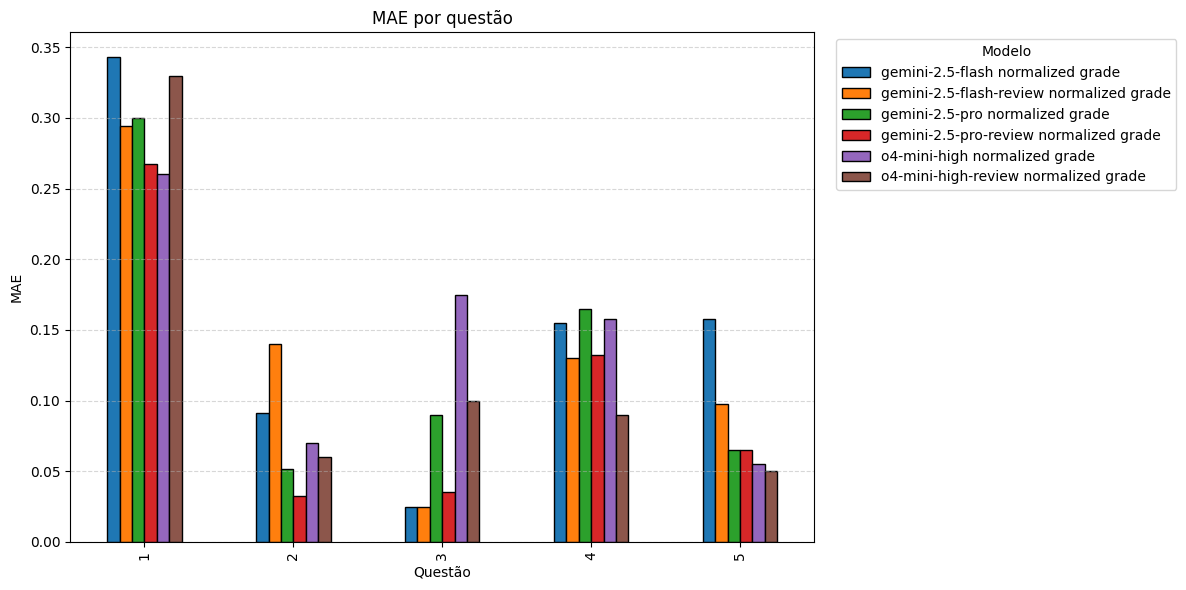

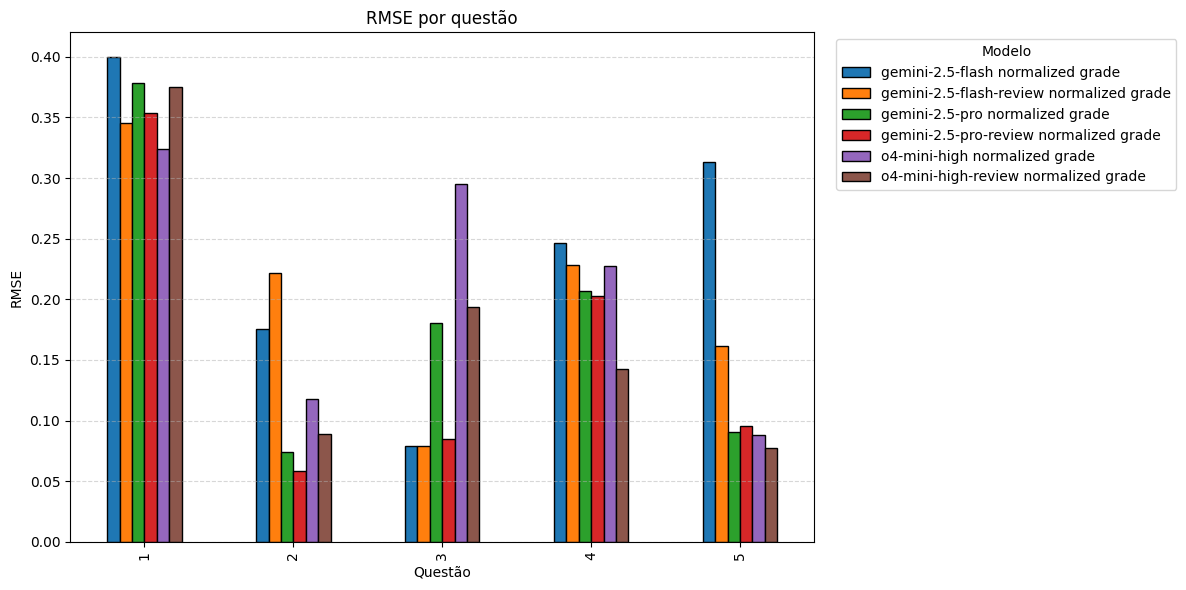

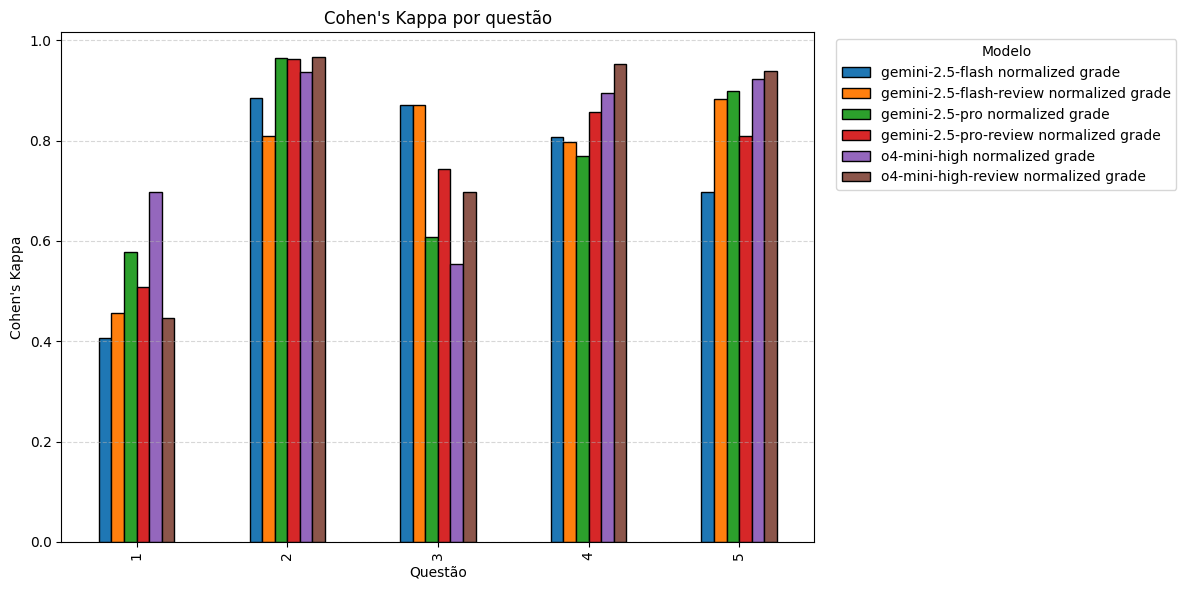

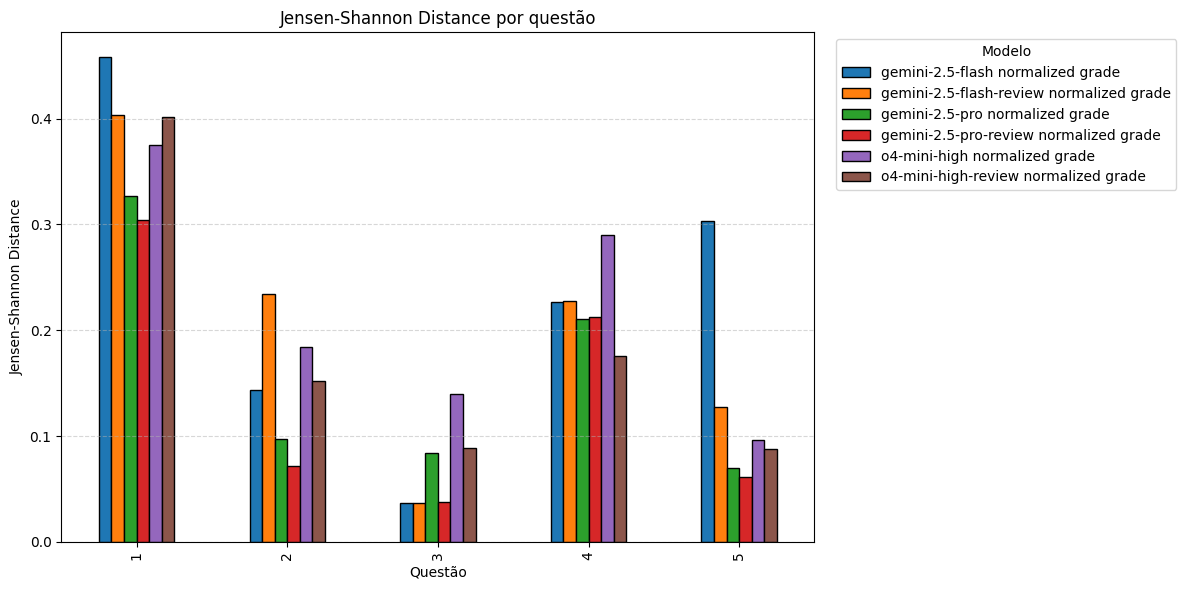

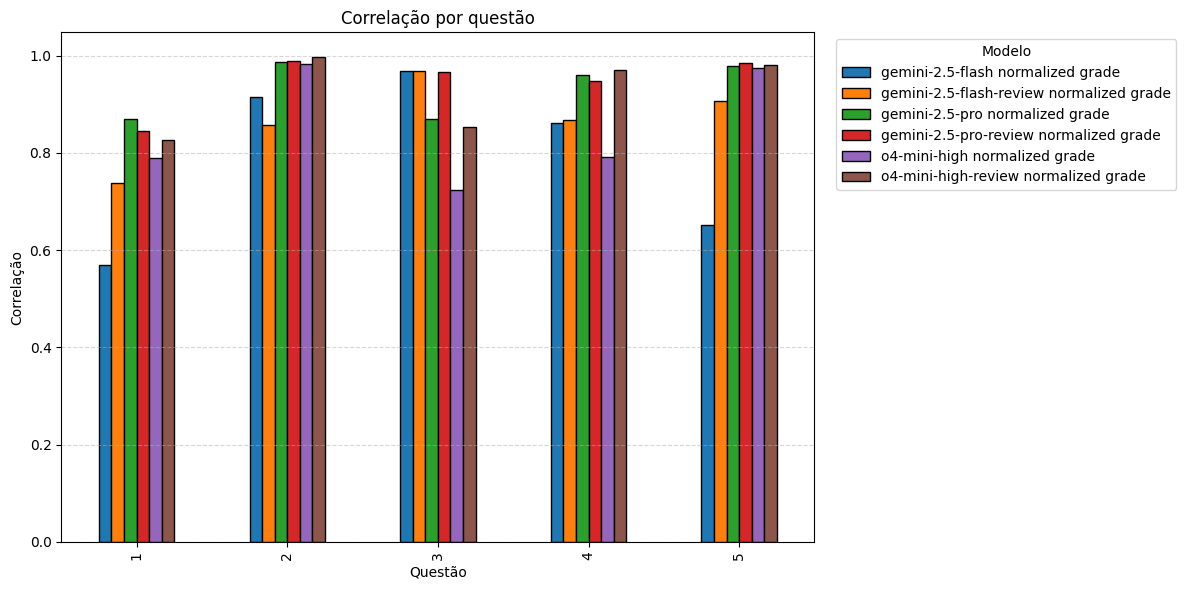

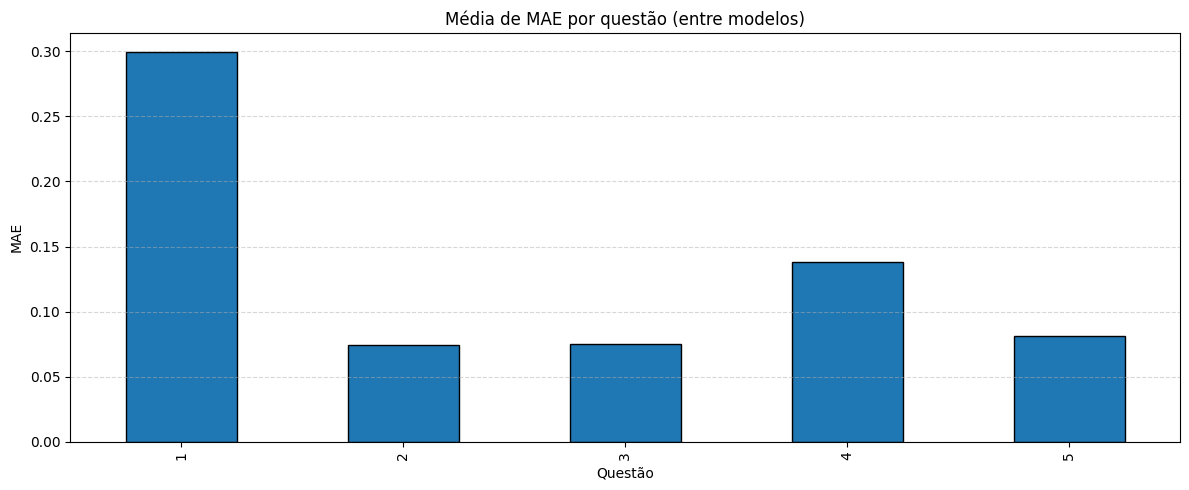

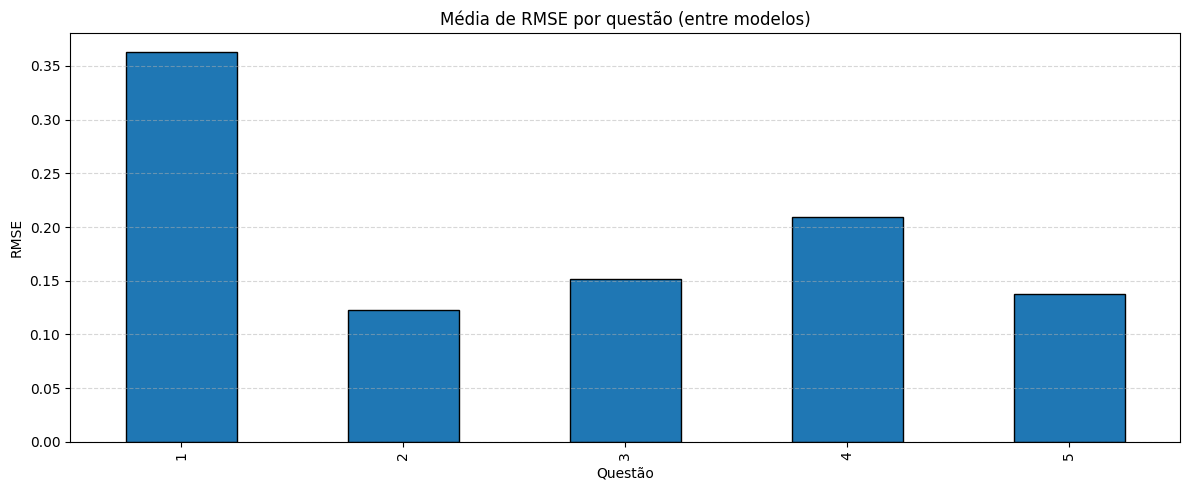

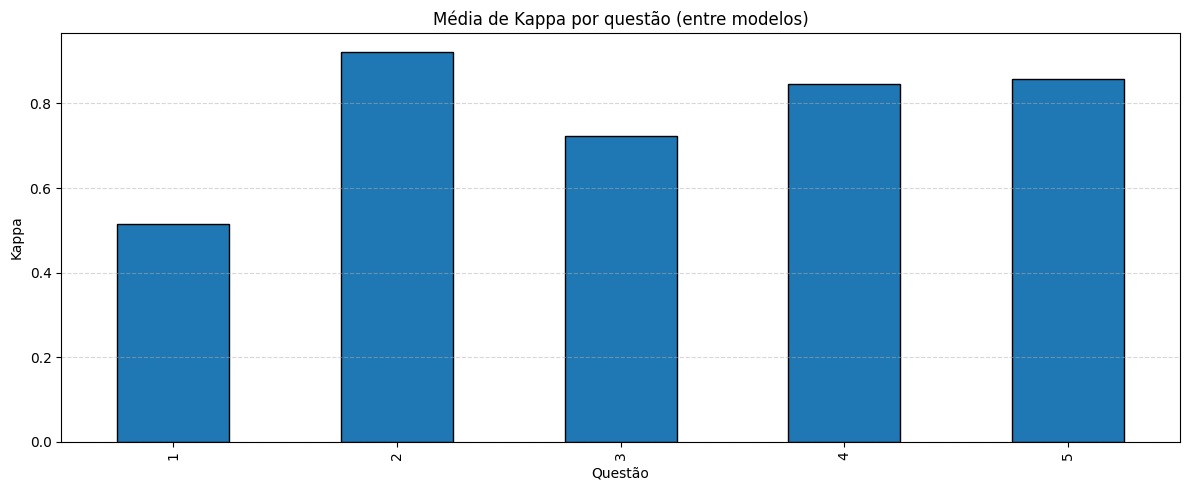

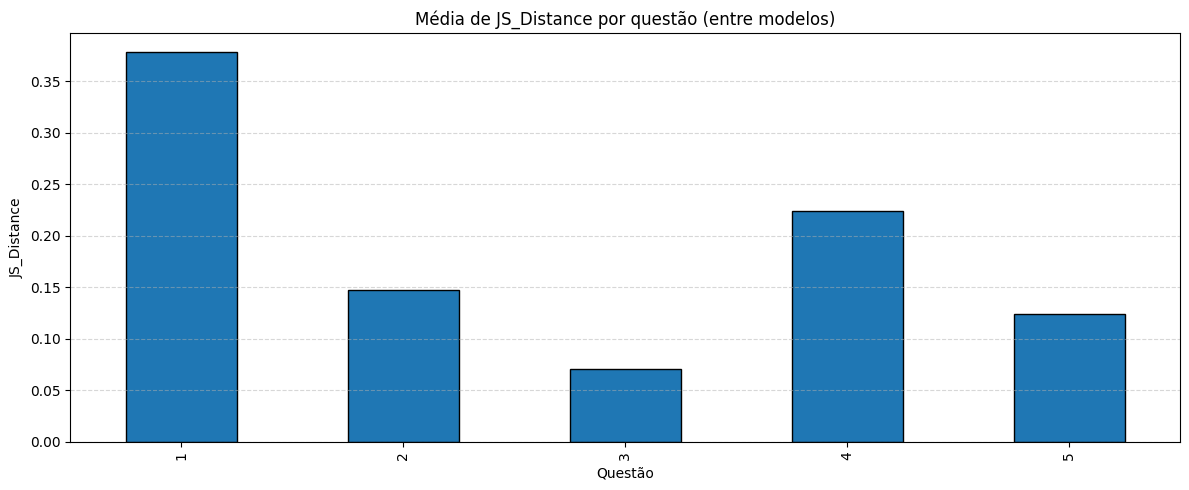

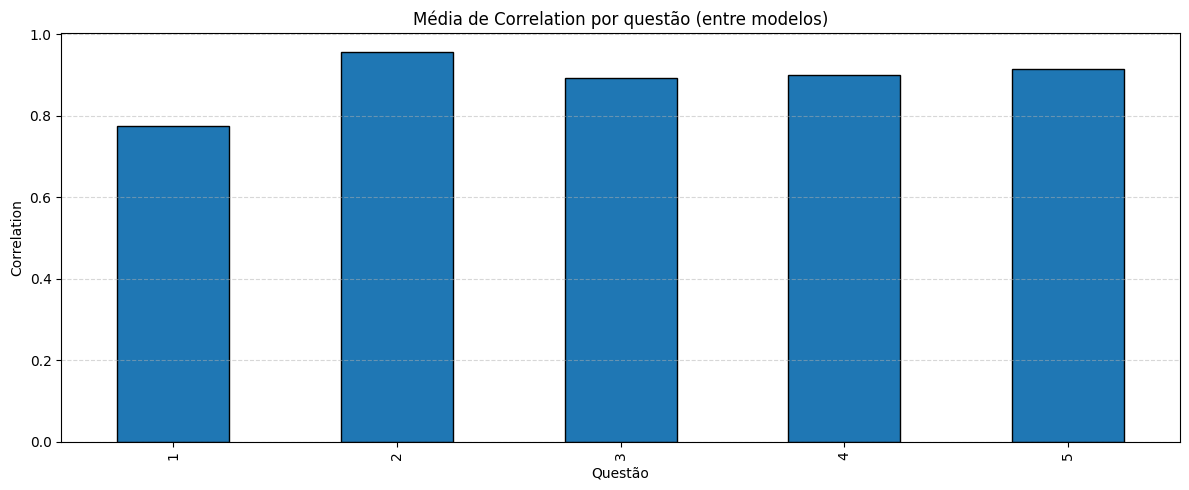

In [ ]:
records = []
for q, df_q in data.groupby(question_col):
    true_q = df_q[true_col]
    for model in models:
        mae, rmse = calculate_metrics(true_q, df_q[model])
        jsd = js_distance(true_q, df_q[model])
        corr = true_q.corr(df_q[model])
        kappa_q = cohen_kappa(true_q, df_q[model], bins)
        records.append({
            question_col: q,
            'model': model,
            'MAE': mae,
            'RMSE': rmse,
            'JS_Distance': jsd,
            'Correlation': corr,
            'Kappa': kappa_q
        })

metrics_by_question_df = pd.DataFrame(records)

# Pivots para plotagens
mae_pivot = metrics_by_question_df.pivot(index=question_col, columns='model', values='MAE')
rmse_pivot = metrics_by_question_df.pivot(index=question_col, columns='model', values='RMSE')
kappa_pivot= metrics_by_question_df.pivot(index=question_col, columns='model', values='Kappa')
js_pivot   = metrics_by_question_df.pivot(index=question_col, columns='model', values='JS_Distance')
corr_pivot = metrics_by_question_df.pivot(index=question_col, columns='model', values='Correlation')

# -----------------------
# Gráficos por questão (barras & heatmap)
# -----------------------
plot_metric_grouped_bar(mae_pivot, "MAE")
plot_metric_grouped_bar(rmse_pivot, "RMSE")
plot_metric_grouped_bar(kappa_pivot, "Cohen's Kappa")
plot_metric_grouped_bar(js_pivot, "Jensen-Shannon Distance")
plot_metric_grouped_bar(corr_pivot, "Correlação")

# -----------------------
# Médias entre modelos por questão
# -----------------------
means_by_question = (
    metrics_by_question_df
    .groupby(question_col)[['MAE', 'RMSE', 'Kappa', 'JS_Distance', 'Correlation']]
    .mean()
    .sort_index()
)

# Plota as quatro métricas
for m in ['MAE', 'RMSE', 'Kappa', 'JS_Distance', 'Correlation']:
    plot_mean_metric_bar(means_by_question, m)